## Latent Semantic Analysis (LSA)

Utilizemos el diccionario creado y el corpus de prueba para ver cómo implementar un modelo, en este caso **Latent Semantic Analysis**. Vamos a utlizar tanto la implementación en **Gensim** (que es más fácil para obtener información de tipo semántica) como la de **Scikit-learn** que nos permite a acceder a más información numérica.

Comenzamos cargando el diccionario y el corpus previamente construidos:


In [1]:
# -*- coding: utf8 -*-
from gensim.corpora import Dictionary
import cPickle as pk

# Cargado del diccionario construido
dictionary = Dictionary.load('tutorial.dict')

# Cargado del corpus como bag or words
corpus = pk.load(file('Tutorial_corpus.pk','r'))

Comenzaremos utlizando la implementación en **Scikit-learn**, para ello lo primero que tenemos que hacer es transformar el corpus como una matriz *sparse* que **Scikit-learn** entiende. **Gensim** nos permite hacer esto fácilmente:

In [2]:
from gensim.matutils import corpus2csc

# Corpus para sklearn
corpus2sklearn = corpus2csc(corpus).T

La transposición (*.T*) nos permite que la matriz quede armada de forma tal que cada documento sea un vector fila en el espacio de términos. Esto se ve inspeccionando las dimensiones de la matriz:

In [3]:
print('Dimensiones: {}'.format(corpus2sklearn.shape))

Dimensiones: (400, 18646)


In [4]:
from scipy.spatial.distance import cosine

# Similitud a partir de la "distancia" coseno:
# 1 - cosine() da el coseno del ángulo entre los vectores argumento, tomado como medida
# de similitud (0.00 vectores ortogonales, 1.00 vectores en la misma dirección)

# Debemos llamar al vector del documento i como corpus2sklearn[i].toarray()[0] 
# dado que tenemos que extraerlo de una matriz comprimida, pero usualmente basta con matrix[i]

aux = 1.00 - cosine(corpus2sklearn[0].toarray()[0], corpus2sklearn[1].toarray()[0])
print(u'Documentos 0 y 1: similitud = {}'.format(aux))

# Correlación entre el documento 0 y el documento 200
aux = 1.00 - cosine(corpus2sklearn[0].toarray()[0], corpus2sklearn[200].toarray()[0])
print(u'Documentos 0 y 200: similitud = {}'.format(aux))

Documentos 0 y 1: similitud = 0.0900233126263
Documentos 0 y 200: similitud = 0.00966285059421


Vemos que la matriz tiene 400 filas que es el número de documentos cargados y 18646 términos que los describen.

### LSA (o SVD)

Hacer LSA es los mismo que descomponer en valores singulares una matriz rectangular (https://es.wikipedia.org/wiki/Descomposici%C3%B3n_en_valores_singulares). Dada la matriz $A$ que en nuestro caso será la matriz de *m* documentos por *n* términos (donde recordemos cada entrada es la frecuencia con la que aparece un dado término en el documento), la descomposición en valores singulares descompone la matriz como:

$$ A^{(m \times n)} = U^{(m \times m)} \cdot S^{(m \times n)} \cdot (V^{(n \times n)})^T $$

La matriz $S$ es una matriz rectangular con los valores singulares en la diagonal del bloque con la dimensión inferior (completando con ceros el resto de las columnas). La reducción de la dimensionalidad se produce cuando se descartan los valores singulares más chicos y se recompone la matriz $A$.
Vamos a utilizar **Scikit-learn** para la aplicación de este modelo. 
El esquema de trabajo en **Scikit-learn** es generalmente el siguiente:
- Importar la clase del modelo que queremos utilizar.
- Creamos un objeto a partir de la clase con los parámetros que querramos.
- Llamamos al método *fit_transform* del objeto creado pasandole como argumentos los datos, en nuestro caso la matriz asociada al corpus.

Por lo tanto comenzamos importanto la clase de SVD:

In [5]:
from sklearn.decomposition import TruncatedSVD

Creamos un objeto a partir de la clase importada. Usualmente **SVD** se utiliza para reducir la dimensionalidad del problema, por lo tanto hay que especificar como argumento cuántas dimensiones vamos a conservar. Como en principio no sabemos nada de los datos utilizamos la dimensión más chica de la matriz del corpus de forma tal de realizar la transformación sin pérdida de información al principio (en este caso la transformación es simplemente un cambio de base):

In [6]:
# Objeto svd a partir de la clase TruncatedSVD
svd = TruncatedSVD(n_components = min(corpus2sklearn.shape)-1)

Transformamos la matriz del corpus a la nueva base:

In [7]:
corpus_transformed = svd.fit_transform(corpus2sklearn)

Vemos que la dimensiones de la matriz corpus transformada es ahora el número de documentos por el número de las nuevas dimensiones:

In [8]:
print(corpus_transformed.shape)

(400, 399)


#### ¿Cuánta información hay contenida en cada dimensión? 
Por defecto, **SVD** ordena las dimensiones por cantidad de información contenida, es decir la primer dimensión tiene más información que la segunda, la segunda más que la tercera, etc. Podemos acceder a la fracción de varianza explicada en cada dimensión mediante el siguiente método del objeto **svd**:

In [9]:
# Vemos la fracción de los primeras 20 dimesiones
print(svd.explained_variance_ratio_[:20])

[0.06024648 0.07750942 0.03829153 0.0360149  0.02902977 0.02499114
 0.02120786 0.01580438 0.01478186 0.0126623  0.01251634 0.01219027
 0.01084258 0.0087837  0.0086163  0.00778815 0.00753736 0.00740165
 0.00721298 0.00714912]


Finalmente veamos gráficamente el acumulado de información a medida que aumentamos el número de dimensiones:

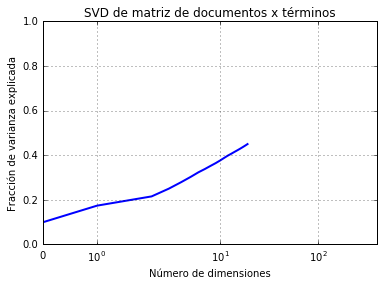

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(1)
plt.plot(np.cumsum(svd.explained_variance_ratio_), linewidth = 2)
plt.xscale('symlog')
plt.xlim([0, 400])
plt.xlabel(u'Número de dimensiones')
plt.ylabel(u'Fracción de varianza explicada')
plt.title(u'SVD de matriz de documentos x términos')
plt.ylim([0.00, 1.00])
plt.grid('on')
plt.show()

Del último gráfico podemos observar por ejemplo que 10 son suficientes para explicar alrededor del 35% de la información y con 100 dimensiones alreder del 70%. Con 20 dimensiones se explica alrededor del 40%, por lo tanto optamos entonces por recudir nuestra matriz a este número de dimensiones (para ello debemos construir nuevamente el objeto):

In [11]:
svd = TruncatedSVD(20)

In [12]:
corpus_transformed = svd.fit_transform(corpus2sklearn)

# Veamos la dimensión final
print('Dimensiones: {}'.format(corpus_transformed.shape))

Dimensiones: (400, 20)


In [13]:
# Similitud entre el documento 0 y el documento 1
aux = 1.00 - cosine(corpus_transformed[0], corpus_transformed[1])
print(u'Documentos 0 y 1: similitud = {}'.format(aux))

# Similitud entre el documento 0 y el documento 200
aux = 1.00 - cosine(corpus_transformed[0], corpus_transformed[200])
print(u'Documentos 0 y 200: similitud = {}'.format(aux))

Documentos 0 y 1: similitud = 0.643613682036
Documentos 0 y 200: similitud = 0.0295281460382


### Descripción del problema en el espacio de términos

En el paper original de LSA [CITAR], describen la matriz de interés como una matriz de *m* términos por *n* documentos, y analizan la similitud entre términos. Hagamos eso, repitiendo prácticamente el mismo análisis que antes pero sin trasponer la matriz dada por *Gensim*:

In [14]:
# Utilizamos la matriz tal como la entrego gensim
corpus2sklearn = corpus2csc(corpus)

print('Dimensiones: {}'.format(corpus2sklearn.shape))

Dimensiones: (18646, 400)


Vemos que nuestra matriz de interés tiene como vectores filas todos los términos utlizados para la descripción del corpus. ¿Cómo es la relación entre las filas y los términos? Se lo preguntamos al diccionario: si queremos averiguar en qué fila se ubica un término específico llamamos al método token2id:

In [15]:
print('aborto - fila: {}'.format(dictionary.token2id[u'aborto']))
print(u'despenalización - fila: {}'.format(dictionary.token2id[u'despenalización']))
print(u'trump - fila {}'.format(dictionary.token2id[u'trump']))

aborto - fila: 0
despenalización - fila: 1267
trump - fila 435


In [16]:
# Similitud entre términos 
aux = 1.00 - cosine(corpus2sklearn[0].toarray()[0], corpus2sklearn[1267].toarray()[0])
print(u'aborto y despenalización: similitud = {}'.format(aux))

aux = 1.00 - cosine(corpus2sklearn[0].toarray()[0], corpus2sklearn[435].toarray()[0])
print(u'aborto y trump: similitud = {}'.format(aux))

aborto y despenalización: similitud = 0.538457149861
aborto y trump: similitud = 0.00594193008084


Apliquemos **SVD** para ver cuál es el efecto de reducir la dimensionalidad del problema. Inspeccionamos primero la cantidad de información contenida en cada dimensión realizando una transformación prácticamente sin pérdida de información:

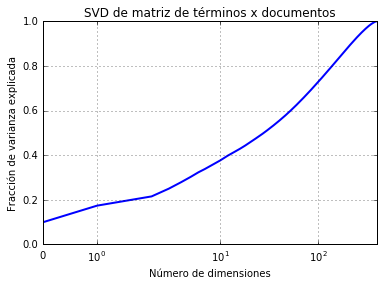

In [17]:
# Objeto svd a partir de la clase TruncatedSVD
svd = TruncatedSVD(n_components=min(corpus2sklearn.shape)-1)

corpus_transformed_terms = svd.fit_transform(corpus2sklearn)

plt.figure(2)
plt.plot(np.cumsum(svd.explained_variance_ratio_), linewidth = 2)
plt.xscale('symlog')
plt.xlim([0, 400])
plt.xlabel(u'Número de dimensiones')
plt.ylabel(u'Fracción de varianza explicada')
plt.title(u'SVD de matriz de términos x documentos')
plt.ylim([0.00, 1.00])
plt.grid('on')
plt.show()


Reteniendo solo 20 dimensiones, al igual que antes, se explica alrededor del 40% de la varianza. Aplicamos entonces **SVD** con este número de dimensiones, obteniendo una descripción de los términos descriptos en un espacio reducido, cuya vectores base son combinaciones lineales de los documentos.

In [18]:
svd = TruncatedSVD(20)

corpus_transformed_terms = svd.fit_transform(corpus2sklearn)

Inspeccionamos la dimesiones de la matriz transformada:

In [19]:
print('Dimensiones: {}'.format(corpus_transformed_terms.shape))

Dimensiones: (18646, 20)


Finalmente, vemos cuál fue el efecto de la reducción de la dimensionalidad en la correlación entre términos:

In [20]:
aux = 1.00 - cosine(corpus_transformed_terms[0], corpus_transformed_terms[1267])
print(u'aborto y despenalización: similitud = {}'.format(aux))

aux = 1.00 - cosine(corpus_transformed_terms[0], corpus_transformed_terms[435])
print(u'aborto y trump: similitud = {}'.format(aux))

aborto y despenalización: similitud = 0.786915879647
aborto y trump: similitud = 0.00549250251486
